# Parameter Distributions

In [1]:
import numpy as np
from utils import plotting

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

burn_in = 0.2

We will first look at the parameter distribution of the symsparse models:

In [64]:
data_name = "G13_COAD_12"

samples = np.load(
    "../results/mcmc/G13_LUAD_12_symsparse_MALA_0_001421875.npy"
    if data_name == "G13_LUAD_12"
    else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy"
    if data_name == "G13_COAD_12"
    else None
    )
samples = samples[:, int(burn_in * samples.shape[1]):]
samples = samples.reshape(-1, samples.shape[2])

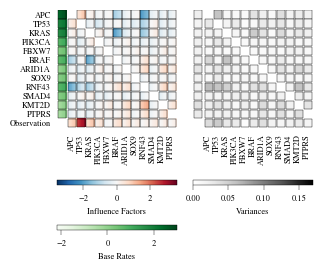

In [65]:
tile_len = 10

quantiles = np.quantile(samples,
                        np.linspace(0.05, 0.95, tile_len),
                        axis=0).T.reshape(13, -1)
variances = np.var(samples, axis=0).reshape(13, -1)

fig = plt.figure(figsize=(3.21, 2.8))
gs = mpl.gridspec.GridSpec(
    3, 2, height_ratios= [1., 0.035, 0.035])

border_len = 0.1
br_ir_sep = 0.2

ax = np.array([
    fig.add_subplot(gs[0, i]) for i in range(2)])
cbar_ax = np.array([fig.add_subplot(gs[1 + i // 2, i % 2])
                   for i in range(3)])

# br_min,  = min(plotting.min_max_br(q, tile_len)[0]
#              for q in [quantiles, coad_quantiles])
# br_max = max(plotting.min_max_br(q, tile_len)[1]
#              for q in [quantiles, coad_quantiles])
# max_abs_ir = max(plotting.max_abs_ir(q, tile_len)
#                  for q in [quantiles, coad_quantiles])
# max_var = max(v.max() for v in [variances, coad_variances])

br_min = -2.2
br_max = 3
max_abs_ir = 3.6
max_var = 0.17

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)
n_events = data.shape[1]
event_names = data.columns.tolist()

plotting.plot_theta_dist(
    quantiles=quantiles,
    tile_len=tile_len,
    n_events=n_events,
    abs_max_ir=max_abs_ir,
    min_br=br_min,
    max_br=br_max,
    events=event_names,
    ax=ax[0])
plotting.plot_theta_var(
    variances=variances,
    n_events=n_events,
    max_var=max_var,
    events=event_names,
    ax=ax[1])

ax[0].set_yticks(np.arange(0.5, n_events + 1 +
                                n_events * border_len, 1 + border_len))
ax[0].set_yticklabels(
    event_names + ["Observation"], )
ax[0].tick_params(length=0, pad=4)

for j in range(2):
    ax[j].set_xticks(
        [0.5]
        + (np.arange(1.5, n_events + 1 + n_events *
                        border_len,
                        1 + border_len) + br_ir_sep).tolist())
    ax[j].set_xticklabels([""] + event_names, rotation=90)
    ax[j].tick_params(length=0, pad=4)

cbars = list()
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=-max_abs_ir, vmax=max_abs_ir), cmap="RdBu_r"),
    cax=cbar_ax[0],
    label="Influence Factors",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=0, vmax=max_var), cmap="Greys"),
    cax=cbar_ax[1],
    label="Variances",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=br_min, vmax=br_max), cmap="Greens"),
    cax=cbar_ax[2],
    label="Base Rates",
    orientation="horizontal",
))

for cbar in cbars:
    cbar.outline.set_linewidth(0.3)
    cbar.ax.tick_params(width=0.3)

fig.tight_layout()
fig.savefig(f"../results/figs/{data_name}_param_dist.pdf")

## Parameter Distribution of the L1 Models

Now, let us load the L1 samples

In [66]:
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA

In [178]:
data_name = "G13_COAD_12"

samples = np.load(
    "../results/mcmc/G13_LUAD_12_l1_MALA_0_001.npy" 
    if data_name == "G13_LUAD_12" 
    else "../results/mcmc/G13_COAD_12_l1_MALA_0_001421875.npy")[:,::10]
samples = samples[:, int(burn_in * samples.shape[1]):]
samples = samples.reshape(-1, samples.shape[2])

In [179]:
# clusterable_embedding = umap.UMAP(n_components=3).fit_transform(mmala_log_thetas_r[::10,])
n_components = 3
clusterable_embedding = umap.UMAP(n_components=n_components, random_state=0)\
    .fit_transform(samples)
labels = HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=n_components).fit_transform(samples)
clustered = (labels >= 0)

/home/lhu/mhn_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


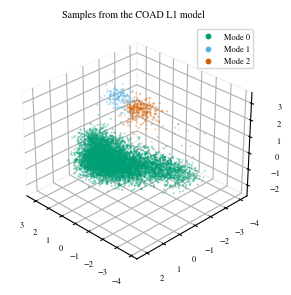

In [180]:
if n_components == 3:
    fig = plt.figure(figsize=(3.21, 3.21))
    ax = fig.add_subplot(projection='3d')
else:
    fig, ax = plt.subplots(figsize=(3.21, 3.21))
for label in np.unique(labels):
    if label == -1:
        continue
    ax.scatter(
        *standard_embedding[labels == label].T,
        s=0.1,
        label=f"Mode {label}"
    )
if n_components == 3:
    ax.view_init(azim=45 if data_name == "G13_LUAD_12" else 135)

legend = ax.legend(markerscale=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
_ = ax.set_title(f"Samples from the {data_name.split('_')[1]} L1 model")

fig.savefig(
    f"../results/figs/{data_name}_l1_pca.pdf"
)

/tmp/ipykernel_1692549/4059998172.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(markerscale=10)


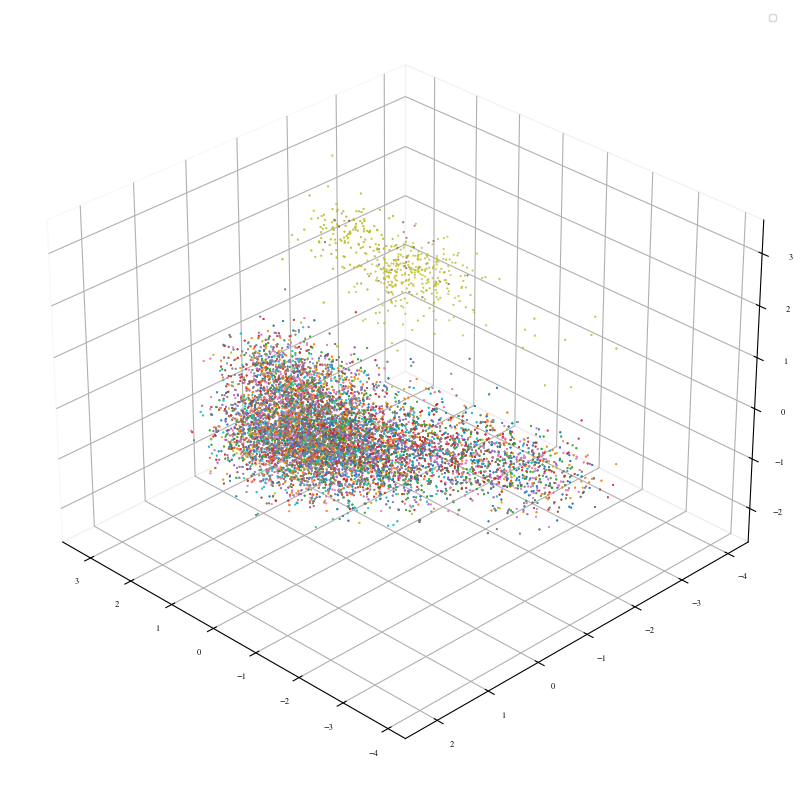

In [181]:
if n_components == 3:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
else:
    fig, ax = plt.subplots(figsize=(3.21, 3.21))
for label in np.unique(labels):
    if label == -1:
        continue
    ax.scatter(
        *standard_embedding.T,
        s=0.2,
        c = np.repeat(np.arange(10), samples.shape[0] // 10),
        cmap="tab10"
    )
if n_components == 3:
    ax.view_init(azim=45 if data_name == "G13_LUAD_12" else 135)

legend = ax.legend(markerscale=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

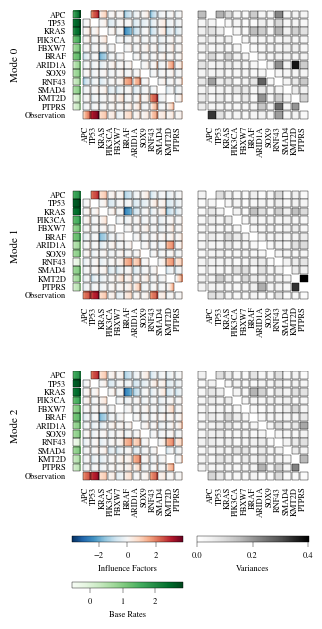

In [182]:
tile_len = 10

quantiles = [np.quantile(samples[labels == label],
                         np.linspace(0.05, 0.95, tile_len),
                         axis=0).T.reshape(13, -1)
             for label in np.unique(labels) if label != -1]
variances = [np.var(samples[labels == label], axis=0).reshape(
    13, -1) for label in np.unique(labels) if label != -1]

n_rows = 3
fig = plt.figure(figsize=(3.21, 2.1 * n_rows + 0.12))
gs = mpl.gridspec.GridSpec(
    n_rows + 2, 2, height_ratios=[1] * n_rows + [0.04, 0.04])

border_len = 0.1
br_ir_sep = 0.2

ax = np.array([[
    fig.add_subplot(gs[j, i])
    for i in range(2)] for j in range(3)])
cbar_ax = np.array([fig.add_subplot(gs[n_rows + i // 2, i % 2])
                   for i in range(3)])

br_min = min(plotting.min_max_br(q, tile_len)[0]
             for q in quantiles)
br_max = max(plotting.min_max_br(q, tile_len)[1]
             for q in quantiles)
max_abs_ir = max(plotting.max_abs_ir(q, tile_len)
                 for q in quantiles)
max_var = max(v.max() for v in variances)

for i, (mode_name, _quantiles, _variances) in enumerate(
    zip(["Mode 0", "Mode 1", "Mode 2"],
        quantiles,
        variances)
):

    data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)
    n_events = data.shape[1]
    event_names = data.columns.tolist()

    ax[i, 0].set_ylabel(mode_name, fontsize=8)
    plotting.plot_theta_dist(
        quantiles=_quantiles,
        tile_len=tile_len,
        n_events=n_events,
        abs_max_ir=max_abs_ir,
        min_br=br_min,
        max_br=br_max,
        events=event_names,
        ax=ax[i, 0])
    plotting.plot_theta_var(
        variances=_variances,
        n_events=n_events,
        max_var=max_var,
        events=event_names,
        ax=ax[i, 1])

    ax[i, 0].set_yticks(np.arange(0.5, n_events + 1 +
                                  n_events * border_len, 1 + border_len))
    ax[i, 0].set_yticklabels(
        event_names + ["Observation"], )
    ax[i, 0].tick_params(length=0, pad=4)

    for j in range(2):
        ax[i, j].set_xticks(
            [0.5]
            + (np.arange(1.5, n_events + 1 + n_events *
                         border_len,
                         1 + border_len) + br_ir_sep).tolist())
        ax[i, j].set_xticklabels([""] + event_names, rotation=90)
        ax[i, j].tick_params(length=0, pad=4)

cbars = list()
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=-max_abs_ir, vmax=max_abs_ir), cmap="RdBu_r"),
    cax=cbar_ax[0],
    label="Influence Factors",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=0, vmax=max_var), cmap="Greys"),
    cax=cbar_ax[1],
    label="Variances",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=br_min, vmax=br_max), cmap="Greens"),
    cax=cbar_ax[2],
    label="Base Rates",
    orientation="horizontal",
))

for cbar in cbars:
    cbar.outline.set_linewidth(0.3)
    cbar.ax.tick_params(width=0.3)

# fig.suptitle(f"Parameter distributions of different modes from {data_name.split('_')[1]} L1 model", fontsize=10)
fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_l1_param_dist_modes.pdf"
)

In [183]:
means = [np.mean(samples[labels == label], axis=0) for label in np.unique(labels) if label != -1]

In [184]:
differential_params = np.ndarray(0)
for i in range(3):
    for j in range(i+1, 3):
        differential_params = np.concatenate([differential_params, np.where(
            np.abs(means[i] - means[j]) > 0.6)[0]])
differential_params = np.unique(differential_params).astype(int)

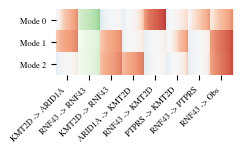

In [185]:
fig, ax = plt.subplots(figsize=(len(differential_params) * 0.3, 2.1))

for m, index in enumerate(differential_params):
    index_i, index_j = (index // 12), (index % 12)
    for i in range(3):
        ax.imshow(
            quantiles[i][[index_i], index_j*tile_len:(index_j+1)*tile_len],
            aspect='equal',
            cmap='Greens' if index_i == index_j else 'RdBu_r',
            vmin=br_min if index_i == index_j else -max_abs_ir,
            vmax=br_max if index_i == index_j else max_abs_ir,
            extent=(m-0.5, m + 0.5, i-0.5, i+0.5)
        )
ax.set_xticks(ticks=np.arange(len(differential_params)),
           labels=[f"{event_names[index % 12]} -> {(event_names + ['Obs'])[index // 12]}"
                    for index in differential_params], rotation=45, ha='right')
ax.set_yticks(ticks=np.arange(3), labels=[f"Mode {i}" for i in range(3)])
ax.set_xlim(-0.5, len(differential_params)-0.5)
ax.set_ylim(2.5, -0.5)

for spine in ax.spines.keys():
    ax.spines[spine].set_visible(False)
fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_l1_param_dist_differential.pdf",
)